In [2]:
import pathlib
import pickle

import matplotlib.pyplot as plt
import tqdm
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn

from super_resolution.src.sen2venus_dataset import (
    create_train_validation_test_split,
    default_patch_transform,
    create_train_test_split
)

from super_resolution.src.visualization import plot_gallery

## Loading train and test images

In [115]:
from super_resolution.src.visualization import plot_gallery

DATA_DIR = pathlib.Path("C:/Users/skouf/Documents/2024/STAT3007/data")
SITES_DIR = DATA_DIR / "sites"
PREPROCESSING_DIR = DATA_DIR / "preprocessing"
RESULTS_DIR = DATA_DIR / "results"

train_patches, val_patches, test_patches = create_train_validation_test_split(
    str(SITES_DIR) + "\\", sites={"ATTO"}
)

print(
    f"Num train {len(train_patches)}\n"
    f"Num validation {len(val_patches)}\n"
    f"Num test {len(test_patches)}"
)

Num train 1580
Num validation 339
Num test 339


## SRCNN Architecture

In [5]:
class SRCNN(nn.Module):
    def __init__(self,f1=9,n1=64,f2=1,n2=32,f3=5,c=3):
        super().__init__()
        p1 = (f1 - 1)//2
        p2 = (f2 - 1)//2
        p3 = (f3 - 1)//2
        self.upscale = nn.Sequential(nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False),
                                     nn.Conv2d(c, n1, f1,padding=p1),
                                     nn.ReLU(),
                                     nn.Conv2d(n1,n2,f2,padding=p2),
                                     nn.ReLU(),
                                     nn.Conv2d(n2,c,f3,padding=p3),
                                     )
    def forward(self,x):
        return self.upscale(x)

In [ ]:
def output_size(N,F,P=0,D=1,S=1):
    return (N + 2*P - D*(F-1)-1)//S + 1

In [7]:
model = SRCNN()
print(model)

SRCNN1(
  (upscale): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bicubic')
    (1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (2): ReLU()
    (3): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)


## Training

In [96]:
import torch.optim as optim
# from torch.utils.data import DataLoader
import tqdm
from torch.utils.data import DataLoader, Dataset
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
should_pin_memory = {"cuda": True, "cpu": False}

def train(model, train_patches, lossfunc = nn.MSELoss(), 
          batch_size = 8, nepochs = 10, lr = 10e-4):
    
    torch.cuda.empty_cache()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    should_pin_memory = {"cuda": True, "cpu": False}
    losses = []
    epoch_losses = [] 
    model = model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    

    train_loader = DataLoader(
        train_patches,
        shuffle=True,  # Always set to true for training
        batch_size=128,  # Always try to set as powers of 2
        drop_last=True,  # Ensures batch size is always the one given (Drops last if its is smaller)
        pin_memory=should_pin_memory[device.type],  # Faster push to GPU
        num_workers=2,  # Load data in parallel but costs more memory
    )

    for epoch in range(nepochs):
        progress_bar = tqdm(train_loader, total=len(train_loader), ncols=110)
        epoch_loss = 0.0
        n_batches = 0
        for low_res_batch, high_res_batch in progress_bar:
            # Push to GPU
            low_res_batch = low_res_batch.to(device)
            high_res_batch = high_res_batch.to(device)
            n_batches += 1

            optimizer.zero_grad()

            # Loss and update
            out = model(low_res_batch)
            loss = lossfunc(out, high_res_batch)
            loss.backward()
            optimizer.step()

            # Collect data
            epoch_loss += loss.item()
            losses.append(loss.item())
            progress_bar.set_postfix(epoch=epoch, batch_loss=loss.item())

        epoch_loss /= len(train_loader)
        epoch_losses.append(epoch_loss)
        print(f"Epoch: {epoch} / loss: {epoch_loss:.3f}")
        

def test(net, test_patches, batch_size = 128, lossfunc=nn.MSELoss()):
    with torch.no_grad(): # disable automatic gradient computation for efficiency
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        model.eval()
        loss = 0

        test_loader = DataLoader(test_patches,
                                shuffle=False,  
                                batch_size=batch_size,  # Always try to set as powers of 2
                                drop_last=True,  # Ensures batch size is always the one given (Drops last if its is smaller)
                                pin_memory=should_pin_memory[device.type],  # Faster push to GPU 
                                )
        
        for low_res_batch, high_res_batch in test_loader:
            # Push to GPU
            low_res_batch = low_res_batch.to(device)
            high_res_batch = high_res_batch.to(device)

            # make predictions and compare
            out = model.forward(low_res_batch)
            loss += lossfunc(out,high_res_batch).item()
    
    return loss

In [ ]:
torch.manual_seed(1)
model = SRCNN()
train(model, train_patches, nepochs=100, batch_size = 128)

In [104]:
torch.save(model,"C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/model.pt")

In [107]:
model = torch.load("C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/model.pt")

In [108]:
print(f"Train set accuracy: {test(model, train_patches):.4f}")
print(f"Test set accuracy: {test(model, test_patches):.4f}")

Train set accuracy: 0.0470
Test set accuracy: 0.0065


## Plotting predictions 

In [109]:
loader = DataLoader(test_patches, batch_size=2)

low_res_examples, high_res_examples = [], []
for i, (low_res, high_res) in enumerate(loader):
    low_res_examples.append(low_res),high_res_examples.append(high_res),
    if i == 2:
        break

low_res_examples, high_res_examples = torch.cat(low_res_examples,dim=0), torch.cat(high_res_examples)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


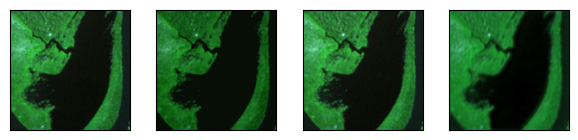

In [114]:
i = 3
out = model.forward(low_res_examples.to(torch.device("cuda")))[i]
x,y = low_res_examples[i], high_res_examples[i]
o = nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False)(low_res_examples)[i]
plot_gallery([x.permute(1,2,0),y.permute(1,2,0),o.permute(1,2,0), out.cpu().detach().permute(1,2,0)])